In [4]:
from pandas_datareader import data as pdr
# pip install pandas-datareader
import quandl
# pip install quandl
from googlefinance import getQuotes
# pip install googlefinance
import json

In [3]:
# Data
StockName = 'PTT'
startDate = '2003-1-1'
endDate = '2021-1-1'

In [4]:
def QueryStockIndex(name, startDate, endDate):
    data = pdr.get_data_yahoo(name, start=startDate, end=endDate)
    return data

In [5]:
stock = QueryStockIndex(StockName + '.BK', startDate, endDate)
print(stock)

              High     Low    Open   Close      Volume  Adj Close
Date                                                             
2003-01-01   4.225   4.225   4.225   4.225         0.0   2.034884
2003-01-02   4.300   4.225   4.225   4.250  18449000.0   2.046925
2003-01-03   4.275   4.225   4.250   4.225  15724000.0   2.034884
2003-01-06   4.250   4.225   4.250   4.250  11980000.0   2.046925
2003-01-07   4.275   4.250   4.250   4.275  22059000.0   2.058966
...            ...     ...     ...     ...         ...        ...
2020-12-24  41.500  40.750  40.750  41.250  45405500.0  40.424999
2020-12-25  42.250  41.250  41.250  42.000  32414000.0  41.160000
2020-12-28  42.750  41.000  42.250  41.000  60698100.0  40.180000
2020-12-29  42.500  41.000  41.250  42.500  41046600.0  41.650002
2020-12-30  43.250  42.250  43.250  42.500  67293300.0  41.650002

[4450 rows x 6 columns]


In [6]:
def QueryOilPrice(startDate, endDate):
    OilPrice = quandl.get("OPEC/ORB", start_date=startDate, end_date=endDate)
    return OilPrice

In [7]:
OPEC = QueryOilPrice(startDate, endDate)
print(OPEC)

            Value
Date             
2003-01-02  30.05
2003-01-03  30.83
2003-01-06  30.71
2003-01-07  29.72
2003-01-08  28.86
...           ...
2020-12-24  50.31
2020-12-28  50.10
2020-12-29  50.16
2020-12-30  50.22
2020-12-31  50.24

[4643 rows x 1 columns]


In [8]:
# write stock data to list
indexStock = []
dataStock = []
closeStock = []
for index, row in stock.iterrows():
    
    date = str(index)[:10]
    indexStock.append(date)
    
    temp = []
    temp.append(row.High)
    temp.append(row.Low)
    temp.append(row.Open)
    temp.append(row.Close)
    temp.append(row.Volume)
    dataStock.append(temp)

    closeStock.append(row.Close)

In [9]:
# write OPEC to list
indexOil = []
dataOil = []
for index, row in OPEC.iterrows():
    date = str(index)[:10]
    indexOil.append(date)

    dataOil.append(row.Value)

In [10]:
# Split date
dateTest = '2020-01'

In [11]:
# cleaning data
TrainStock = []
TrainOil = []
TestStock = []
TestOil = []
testflag = False
for i in indexStock:
    for j in indexOil:
        if(i[:7] == dateTest):
            testflag = True
        
        if (i == j) and not(testflag):
            TrainStock.append(dataStock[indexStock.index(i)])
            TrainOil.append(dataOil[indexOil.index(j)])
        elif (i==j) and testflag:
            TestStock.append(dataStock[indexStock.index(i)])
            TestOil.append(dataOil[indexStock.index(i)])

In [12]:
print('Train = ' + str(len(TrainStock)) + ' (' + str(len(TrainStock)/(len(TrainStock)+len(TestStock))) + ')')
print('Test = ' + str(len(TestStock)) + ' (' + str(len(TestStock)/(len(TrainStock)+len(TestStock))) + ')')

Train = 4174 (0.9456275487086543)
Test = 240 (0.05437245129134572)


In [15]:
# Data split
n_stock, n_oil = 1, 1

rangeDate = n_stock
if n_oil > n_stock:
    rangeDate = n_oil

# Train
X_train = []
y_train = []
for i in range(len(TrainStock)-rangeDate -1):
    temp = []
    for s in range(n_stock):
        for j in range(5):
            temp.append(TrainStock[i+s][j])
    for o in range(n_oil):
        temp.append(TrainOil[i+o])
    X_train.append(temp)
    y_train.append(TrainStock[i+rangeDate +1 ][3]) # +1 for pred 2 day

# Test
X_test = []
y_test = []
for i in range(len(TestStock)-rangeDate -1):
    temp = []
    for s in range(n_stock):
        for j in range(5):
            temp.append(TestStock[i+s][j])
    for o in range(n_oil):
        temp.append(TestOil[i+o])
    X_test.append(temp)
    y_test.append(TestStock[i+rangeDate +1 ][3]) # +1 for pred 2 day

In [6]:
# import
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import joblib  # save model

In [17]:
# SVR model define
C = np.arange(1, 100, 1).tolist()
epsilon = np.arange(0.01, 0.2, 0.01).tolist()
# Doo Process
process = len(C) * len(epsilon)
now_process = 0

bestScore = 0
C_Best = 0
epsilon_Best = 0
for tempC in C:
    for tempEpsilon in epsilon:
        now_process += 1 
        regr = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=tempC, epsilon=tempEpsilon))
        regr.fit(X_train,y_train)

        if regr.score(X_train, y_train) > bestScore:
            bestScore = regr.score(X_train, y_train)
            C_Best = tempC
            epsilon_Best = tempEpsilon

print("C : " + str(C_Best) + "\t epsilon : " + str(epsilon_Best) + "\t R^2 : " + str(bestScore))

C : 99	 epsilon : 0.19	 R^2 : 0.9951749987075369


In [18]:
# Save model
regr = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=C_Best, epsilon=epsilon_Best))
regr.fit(X_train,y_train)
result = regr.score(X_train, y_train)
modelName = StockName + str(result) + '_Date' + dateTest + '_nstock' + str(n_stock) + '_noil' + str(n_oil) + '_C' + str(C_Best) + '_eps' + str(epsilon_Best)
joblib.dump(regr,modelName + '.joblib')

['PTT0.9951749987075369_Date2020-01_nstock1_noil1_C99_eps0.19.joblib']

In [19]:
# load the model from disk
loaded_model = joblib.load(modelName + '.joblib')
print("Load model")

Load model


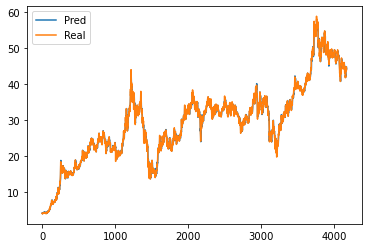

R^2 : 0.9951749987075369


In [21]:
import matplotlib.pyplot as plt

a = []

for i in range(len(X_train)):
    test = loaded_model.predict([X_train[i]])
    a.append(test[0])
plt.plot(a, label='Pred')
plt.plot(y_train, label='Real')
plt.legend()
plt.show()

result = loaded_model.score(X_train, y_train)
print("R^2 : " + str(result))

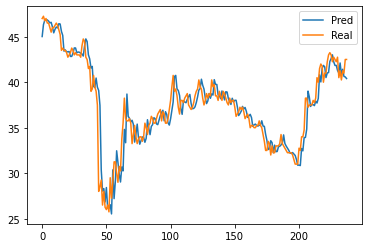

R^2 : 0.881731867899636


In [22]:
import matplotlib.pyplot as plt

a = []

for i in range(len(X_test)):
    test = loaded_model.predict([X_test[i]])
    a.append(test[0])
plt.plot(a, label='Pred')
plt.plot(y_test, label='Real')
plt.legend()
plt.show()

result = loaded_model.score(X_test, y_test)
print("R^2 : " + str(result))

In [44]:
# print(len(X_train))
counter = 0
for i in range(len(X_test)):
    test = loaded_model.predict([X_test[i]])
    if test[0] == y_test[i]:
        counter += 1
print('Accuracy : ' + str(counter / len(X_test)))

Accuracy : 0.0


In [31]:
print(X_test[103])
print(loaded_model.predict([X_test[103]]))
print(y_test[101])

[40.5, 37.5, 38.0, 39.5, 172777600.0, 64.39]
[40.62078685]
39.5


In [45]:
TPos = 0 # ทายว่าขึ้น และขึ้น
TNeg = 0 # ทายว่าลง และลง
FPos = 0 # ทายว่าลง แต่ขึ้น
FNeg = 0 # ทายว่าขึ้น แต่ลง

for i in range(1,len(X_test)):
    test = loaded_model.predict([X_test[i]])
    # TPos
    if (test[0] >= y_test[i-1]) and (y_test[i] >= y_test[i-1]):
        TPos += 1
    # TNeg
    if (test[0] <= y_test[i-1]) and (y_test[i] <= y_test[i-1]):
        TNeg += 1
    # FPos
    if (test[0] < y_test[i-1]) and (y_test[i] > y_test[i-1]):
        FPos += 1
    # FNeg
    if (test[0] > y_test[i-1]) and (y_test[i] < y_test[i-1]):
        FNeg += 1

print('TPos = ' + str(TPos/(len(X_test)-1))) 
print('TNeg = ' + str(TNeg/(len(X_test)-1))) 
print('TPos + TNeg = ' + str((TPos+TNeg)/(len(X_test)-1))) 
print()
print('FPos = ' + str(FPos/(len(X_test)-1))) 
print('FNeg = ' + str(FNeg/(len(X_test)-1))) 
print('FPos + FNeg = ' + str((FPos+FNeg)/(len(X_test)-1)))

TPos = 0.21551724137931033
TNeg = 0.38362068965517243
TPos + TNeg = 0.5991379310344828

FPos = 0.23275862068965517
FNeg = 0.16810344827586207
FPos + FNeg = 0.40086206896551724
